In [1]:
import numpy as np
from tqdm import tqdm
import pymc as pm
import skfem as fem
from skfem import MeshLine, ElementLineP1, Basis, BilinearForm, LinearForm
from skfem.helpers import dot, grad, d, dd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import truncnorm
import scipy.stats as scstats
import scipy.sparse as scsparse
import scipy.optimize as scoptimize
import scipy.linalg as sclinalg

# import pytensor.tensor.subtensor as subtensor
# import pytensor.tensor as tensor
# import pytensor.sparse as sparsetensor
import arviz as az

import pytensor.tensor as at
from pytensor import function, scan, shared, config, printing
from pytensor import grad as ptgrad
import numpy as np
from tqdm import tqdm
from pytensor import sparse

import scienceplots
# plot params
contour_levels = 10
plt.style.use(['science', 'grid'])
color_list = [(253, 231, 37),(194, 223, 35),(134, 213, 73),(82, 197, 105),(42, 176, 127),(30, 155, 138),(37, 133, 142),(45, 112, 142),(56, 88, 140),(67, 62, 133),(72, 33, 115),(68, 1, 84)]
color_list = [tuple(ti/255 for ti in t) for t in color_list]

In [290]:
from skfem.models.poisson import vector_laplace, laplace
from skfem.models.general import divergence

@fem.BilinearForm
def vector_mass(u, v, w):
    return sum(v * u)


@fem.BilinearForm
def port_pressure(u, v, w):
    return sum(v * (u * w.n))


p_inlet = 8.0

mesh = fem.MeshTri().refined(3)
# mesh.refined(4)

boundary = {
    "inlet": mesh.facets_satisfying(lambda x: x[0] == 0),
    "outlet": mesh.facets_satisfying(lambda x: x[0] == 1),
    "wall": mesh.facets_satisfying(lambda x: np.logical_or(x[1] == 0, x[1] == 1)),
}
boundary["ports"] = np.concatenate([boundary["inlet"], boundary["outlet"]])

element = {"u": fem.ElementVectorH1(fem.ElementTriP2()), "p": fem.ElementTriP1()}
basis = {
    **{v: fem.InteriorBasis(mesh, e, intorder=4) for v, e in element.items()},
    **{
        label: fem.FacetBasis(mesh, element["u"], facets=boundary[label])
        for label in ["inlet", "outlet"]
    },
}


M = fem.asm(vector_mass, basis["u"])
L = {"u": fem.asm(vector_laplace, basis["u"]), "p": fem.asm(laplace, basis["p"])}
B = -fem.asm(divergence, basis["u"], basis["p"])
P = B.T + fem.asm(
    port_pressure,
    *(
        fem.FacetBasis(mesh, element[v], facets=boundary["ports"], intorder=3)
        for v in ["p", "u"]
    )
)

t_final = 1.0
dt = 0.025

dirichlet = {
    "u": basis["u"].get_dofs(boundary["wall"]).all(),
    "p": np.concatenate([basis["p"].get_dofs(boundary["ports"]).all()]),
}
inlet_pressure_dofs = basis["p"].get_dofs(boundary["inlet"]).all()

uv_, p_ = (np.zeros(basis[v].N) for v in element.keys())  # penultimate
p__ = np.zeros_like(p_)  # antepenultimate

K = M / dt + L["u"]

t = 0

while t < t_final:

    t += dt

    # Step 1: Momentum prediction (Ern & Guermond 2002, eq. 7.40, p. 274)

    uv = fem.solve(
        *fem.condense(
            K,
            (M / dt) @ uv_ - P @ (2 * p_ - p__),
            np.zeros_like(uv_),
            D=dirichlet["u"],
        )
    )

    # Step 2: Projection (Ern & Guermond 2002, eq. 7.41, p. 274)

    dp = np.zeros(basis["p"].N)
    dp[inlet_pressure_dofs] = p_inlet - p_[inlet_pressure_dofs]

    dp = fem.solve(*fem.condense(L["p"], B @ uv, dp, D=dirichlet["p"]))

    # Step 3: Recover pressure and velocity (E. & G. 2002, p. 274)

    p = p_ + dp

    du = fem.solve(*fem.condense(M / dt, -P @ dp, D=dirichlet["u"]))
    u = uv + du

    uv_ = uv
    p_, p__ = p, p_


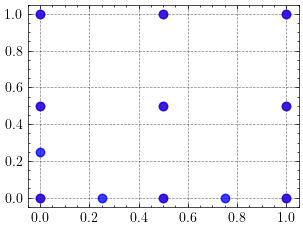

In [291]:
for coordinate in mesh.p.T[:9]:
    plt.scatter(coordinate[0],coordinate[1], color='red', alpha=0.5)


for coordinate in basis['u'].doflocs.T[:24]:
    plt.scatter(coordinate[0],coordinate[1], color='blue', alpha=0.5)

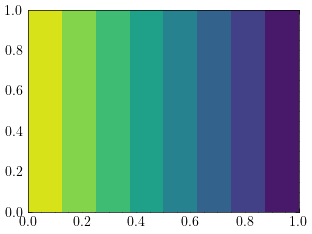

In [292]:
coordinates = mesh.p.T

import matplotlib.tri as tri

xs = coordinates[:,0]
ys = coordinates[:,1]

triang = tri.Triangulation(xs,ys)

plt.tricontourf(triang,p)

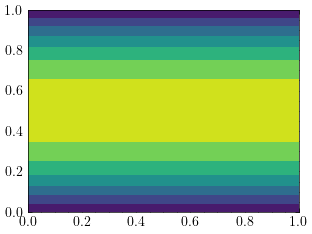

In [297]:
coordinates = basis['u'].doflocs.T[::2]

import matplotlib.tri as tri

xs = coordinates[:,0]
ys = coordinates[:,1]

triang = tri.Triangulation(xs,ys)

plt.tricontourf(triang,uv[::2])